#### Libraries Imported and Setup

In [ ]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


#### EDA


In [ ]:
# working directory
from google.colab import drive
drive.mount('/content/drive')
# Trong moi truong j do, tim hieu kich thuoc cua kieu du lieu

work_dir = '/content/drive/MyDrive/IT2038_KHDL_Nentangungdung/Group_Assignments/Code'
os.chdir(work_dir)
print(f"Đã chuyển đến {os.getcwd()}")

Mounted at /content/drive
Đã chuyển đến /content/drive/MyDrive/IT2038_KHDL_Nentangungdung/Group_Assignments/Code


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import requests
from io import BytesIO
from PIL import Image

# Load image (adjust URL if using a different image)
url = "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).resize((224, 224))
cat_image = np.array(img)

In [ ]:
# Save image
plt.imsave('cat224.png', cat_image)
files.download('cat224.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

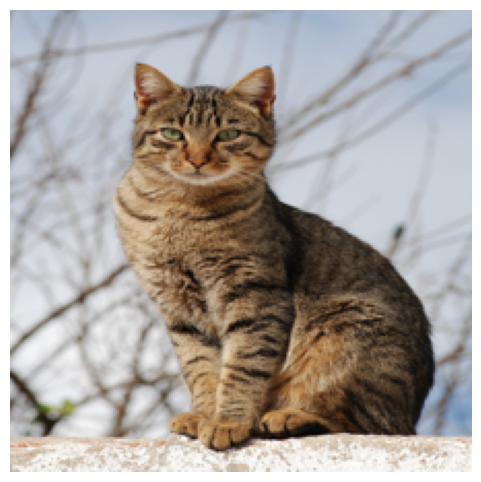

Image shape: (224, 224, 3)


In [ ]:
# Visualize
plt.figure(figsize=(6,6))
plt.imshow(cat_image)
plt.axis('off')
plt.show()

print(f"Image shape: {cat_image.shape}")

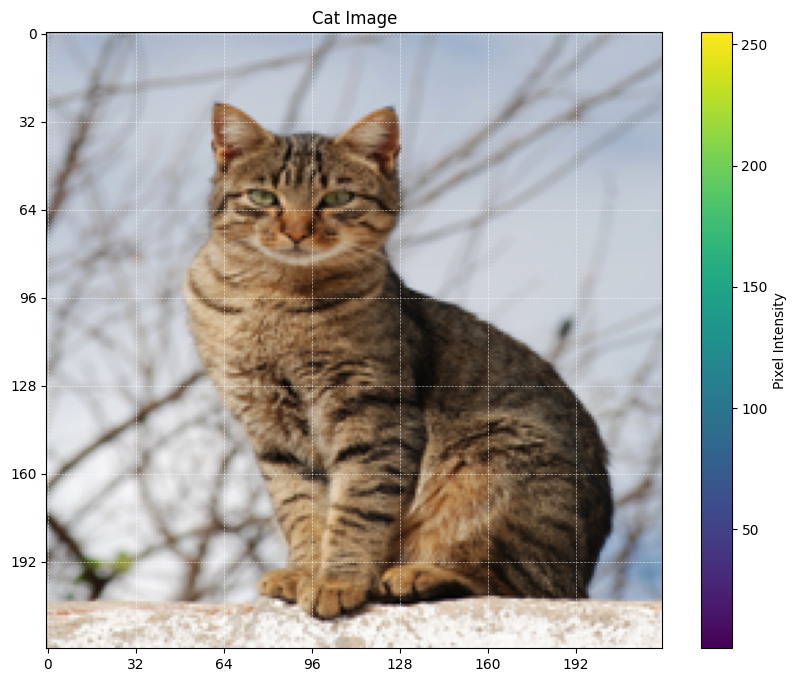

Image shape is 224 x 224, H = 224, W = 224 pixels.


In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cat_image)
plt.title("Cat Image")

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.6)

# Set ticks every x pixels
tick_spacing = 32
plt.xticks(np.arange(0, cat_image.shape[1], tick_spacing))
plt.yticks(np.arange(0, cat_image.shape[0], tick_spacing))

# Add colorbar to show pixel intensity range
plt.colorbar(label='Pixel Intensity')
plt.show()

H, W = cat_image.shape[:2]
print(f"Image shape is {H} x {W}, H = {H}, W = {W} pixels.")

# 8 bit color image, range from 0-255
# colorbar represent the composite of red, green, blue channel intensities.
# Brighter areas correspond to higher pixel value (closer to white) (..255)
# Darker areas represent lower pixel values (closer to black) (0..)
# For the below image:
# - spread of color in the colorbar indicate the image overall contrast, wide spread suggest high contrast, narrow range implies lower contrast
# - dominant tones: earth tone, sky color (middle range of colorbar is blue, green, yellow is prominent)
# - good dynamic range: ultilize nearly full range of pixel intensities
# - color distribution: the progression from purple (dark - car stripes, shadow areas) to yellow (bright - likely the light sky and cat fur) indicates how the combined channel intensities are distributed

In [ ]:
# import gc

# # Clean up
# del x_train, y_train, cat_image
# gc.collect()

There will be 196 patches, each 16 by 16.




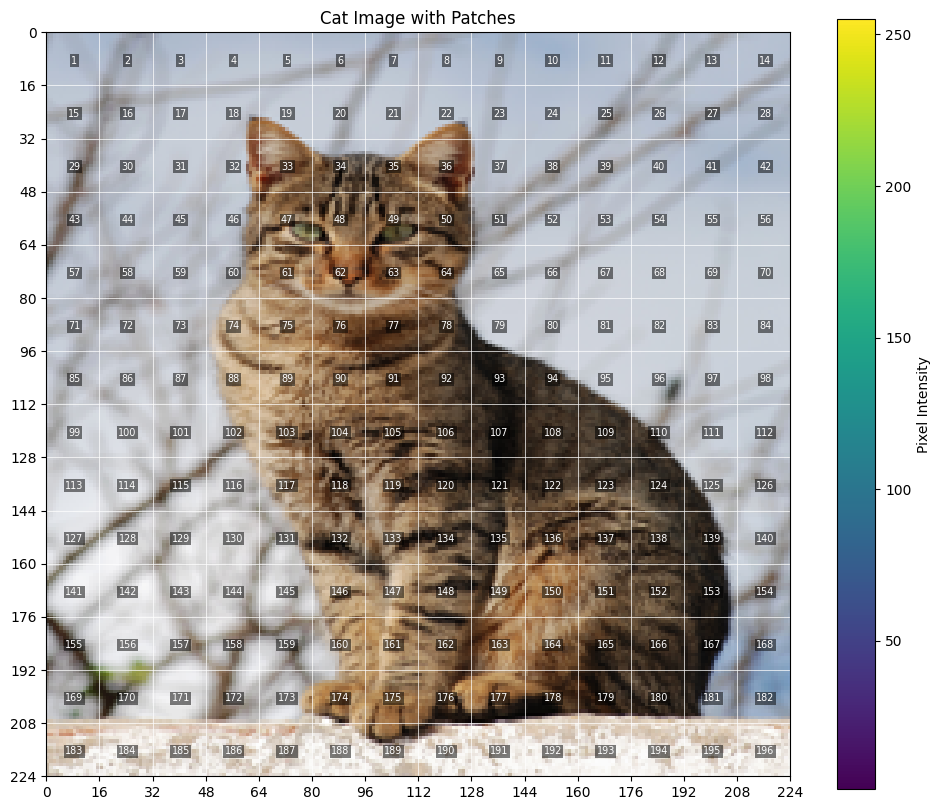

Image shape: (224, 224, 3)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming cat_image is already loaded
H, W = cat_image.shape[:2]

P = 16
N = int((H*W)/(P**2))
print(f"Image shape: {cat_image.shape}")
print(f'There will be {N} patches, each {P} by {P}.')
print('\n')

fig = plt.figure(figsize=(12,10))
plt.imshow(cat_image)
plt.title("Cat Image with Patches")

# Add grid lines
plt.hlines(np.arange(P, H, P)-0.5, -0.5, W-0.5, color='w', linewidth=0.5)
plt.vlines(np.arange(P, W, P)-0.5, -0.5, H-0.5, color='w', linewidth=0.5)

# Set ticks
plt.xticks(np.arange(-0.5, W+1, P), labels=np.arange(0, W+1, P))
plt.yticks(np.arange(-0.5, H+1, P), labels=np.arange(0, H+1, P))

# Add patch numbers
x_text = np.tile(np.arange(P/2, W, P), int(H/P))
y_text = np.repeat(np.arange(P/2, H, P), int(W/P))
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='x-small',
             ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=1))

plt.colorbar(label='Pixel Intensity')
plt.show()



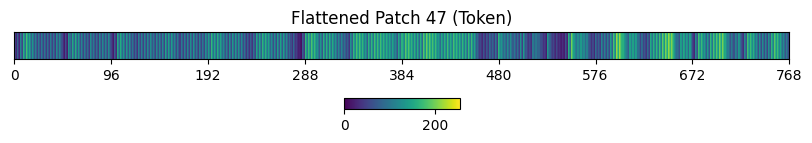

Token shape: (1, 768)
Each patch will make a token of length 768.




In [ ]:
H, W = cat_image.shape[:2]
P = 16


patches_per_row = W // P
def get_patch(patch_number):
    row = (patch_number - 1) // patches_per_row
    col = (patch_number - 1) % patches_per_row
    return cat_image[row*P:(row+1)*P, col*P:(col+1)*P]

# Select patch
patch_number = 47
selected_patch = get_patch(patch_number)

# Flatten the patch into a vector
token = selected_patch.reshape(1, -1)

fig = plt.figure(figsize=(10,1))
plt.imshow(token, aspect='auto', interpolation='nearest', cmap='viridis')
plt.clim([0, 255])
plt.xticks(np.arange(-0.5, P*P*3+1, 96), labels=np.arange(0, P*P*3+1, 96))
plt.yticks([])
plt.title(f"Flattened Patch {patch_number} (Token)")
plt.colorbar(orientation='horizontal', aspect=10, pad=0.5)

plt.show()

print(f"Token shape: {token.shape}")
print(f'Each patch will make a token of length {P*P*3}.')
print('\n')

After extracting tokens from an image, it is common to use a linear projection to change the length of the tokens. This is implemented as a learnable linear layer. The new length of the tokens is referred to as the latent dimension, channel dimension, or the token length. After the projection, the tokens are no longer visually identifiable as a patch from the original image.

##In this simple code, we explain unfold layer and project as follow:
```
self.split is an nn.Unfold layer. Its purpose is to divide the image into patches.

kernel_size: Size of each patch (16x16 in this case)

stride: Distance between patch starts (also 16, so patches don't overlap)

padding=0: No padding is added

# and
self.project is a linear layer that projects each flattened patch to the desired token length.

Input size: (self.patch_size**2)*C (16x16x3 = 768 for RGB images)
Output size: token_len (768 in this case)
```

## We then turn image into set of flattened patches
```
self.split(x): This turns the image into a set of flattened patches.
.transpose(2, 1): This rearranges the dimensions of the output.
self.project(x): This projects each flattened patch to the desired token length.

Thường thì
nn.Unfold output shape: (batch_size, channels*patch_height*patch_width, num_patches)

nên:
transpose(2, 1): (batch_size, num_patches, channels*patch_height*patch_width)

```


## Giải thích dòng lệnh khi sử dụng Pytorch
```
Trong PyTorch, x.shape của một tensor ảnh thường có dạng (batch_size, channels, height, width).

nên _, _, H, W = x.shape đang "unpack" (giải nén) tuple x.shape thành 4 biến.
```





In [ ]:
import torch
import torch.nn as nn

class Patch_Tokenization(nn.Module):
    def __init__(self,
                 img_size: tuple[int, int, int] = (3, 224, 224),
                 patch_size: int = 16,
                 token_len: int = 768):
        """
        Patch Tokenization Module

        Args:
        img_size (tuple[int, int, int]): size of input (channels, height, width)
        patch_size (int): the side length of a square patch
        token_len (int): desired length of an output token
        """
        super().__init__()

        # Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.patch_size = patch_size
        self.token_len = token_len

        assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
        assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'

        self.num_tokens = (H // self.patch_size) * (W // self.patch_size)
        #self.num_patches = math.ceil(img_size[1] / patch_size) * math.ceil(img_size[2] / patch_size)
        #pad_h = (self.num_patches**0.5 * patch_size - img_size[1]) / 2
        #pad_w = (self.num_patches**0.5 * patch_size - img_size[2]) / 2  ## in case image size is not divisible with patch size


        # Defining Layers
        # self.split = nn.Unfold(kernel_size=patch_size, stride=patch_size,
        #                        padding=(math.ceil(pad_h), math.ceil(pad_w)))

        self.split = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size, padding=0)
        self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self, x):
        #  Tự động thêm padding nếu cần
        # _, _, H, W = x.shape
        # pad_h = (self.patch_size - H % self.patch_size) % self.patch_size
        # pad_w = (self.patch_size - W % self.patch_size) % self.patch_size
        # x = nn.functional.pad(x, (0, pad_w, 0, pad_h))


        x = self.split(x).transpose(2, 1)
        x = self.project(x)
        return x

To continue, we’ll use token_len=768 as the projected length, which is the size for the base variant of ViT.I will then change our image datatype from numpy to Torch tensor. Formatted in CHW, unsqueeze to add batch dimension, and then converts the tensor to float32 datatype.
```
# Most image processing libraries and formats use the order (H,W,C)
#PyTorch expect image tensor in the order (C,H,W)

00. x.shape =  (batch_size, channels, height, width)

#that's why we want to permute(rearrange the order)

01. .permute(2, 0, 1)
```



In [ ]:
cat_tensor = torch.from_numpy(cat_image).permute(2, 0, 1).unsqueeze(0).to(torch.float32)

In [ ]:
# Create an instance of Patch_Tokenization
tokenizer = Patch_Tokenization(img_size=(3, 224, 224), patch_size=16, token_len=768)
# Apply tokenization
tokens = tokenizer(cat_tensor)

print(f"Input shape: {cat_tensor.shape}")
print(f"Output shape: {tokens.shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


##### Kiểm tra nhiễu trên bộ dữ liệu gốc, cụ thể trên 1 ảnh gốc

In [ ]:
# Tải dataset CIFAR-100 mà không áp dụng bất kỳ biến đổi nào
trainset = torchvision.datasets.CIFAR100(root='./orgData', train=True, download=True, transform=None)

# Lấy ảnh và nhãn đầu tiên
image, label = trainset[0]

# Chuyển đổi ảnh thành numpy array
image_np = np.array(image)

print(f"Kích thước ảnh: {image_np.shape}")
print(f"Nhãn: {label}")
print(f"Tên lớp: {trainset.classes[label]}")

# Hiển thị thông tin về giá trị pixel
print(f"\nKiểu dữ liệu của ảnh: {image_np.dtype}")
print(f"Giá trị pixel nhỏ nhất: {image_np.min()}")
print(f"Giá trị pixel lớn nhất: {image_np.max()}")
print(f"Giá trị pixel trung bình: {image_np.mean():.2f}")
print(f"Độ lệch chuẩn của giá trị pixel: {image_np.std():.2f}")


Files already downloaded and verified
Kích thước ảnh: (32, 32, 3)
Nhãn: 19
Tên lớp: cattle

Kiểu dữ liệu của ảnh: uint8
Giá trị pixel nhỏ nhất: 1
Giá trị pixel lớn nhất: 255
Giá trị pixel trung bình: 138.30
Độ lệch chuẩn của giá trị pixel: 72.51



Ước lượng mức độ nhiễu: 53.24


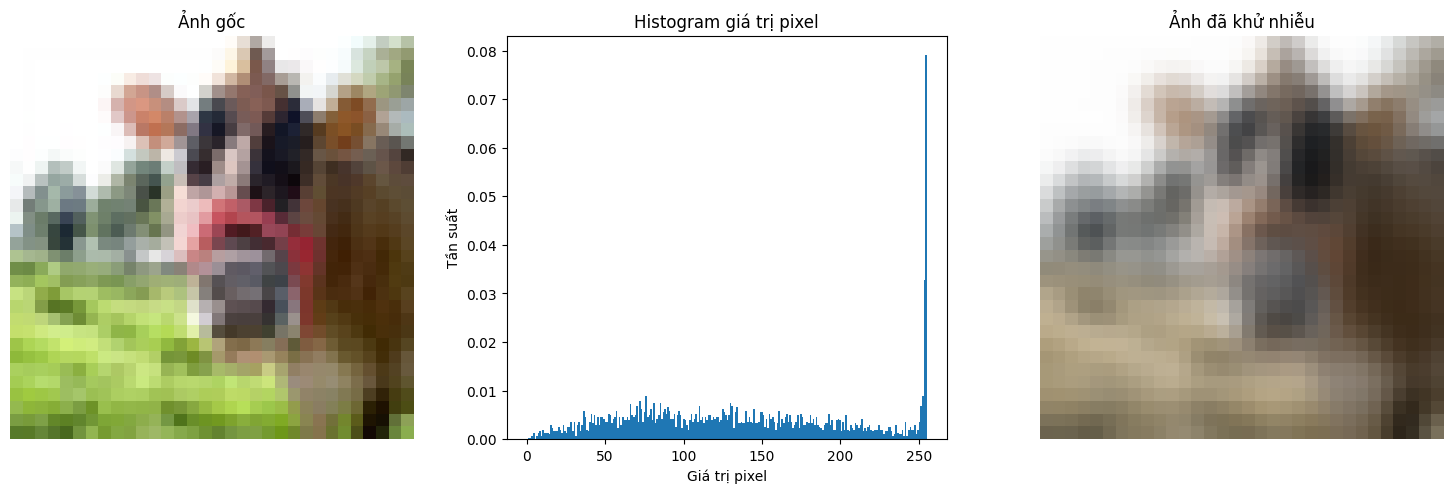

In [ ]:
# Ước tính nhiễu đơn giản bằng cách tính độ lệch chuẩn trong vùng đồng nhất
def estimate_noise(image, patch_size=5):
    if len(image.shape) == 3:  # Ảnh màu
        return np.mean([estimate_noise(image[:,:,i], patch_size) for i in range(image.shape[2])])
    H, W = image.shape
    Z = image[:(H//patch_size)*patch_size, :(W//patch_size)*patch_size]
    Z = Z.reshape(-1, patch_size, patch_size)
    return np.mean(np.std(Z, axis=(1,2)))

noise_est = estimate_noise(image_np)
print(f"\nƯớc lượng mức độ nhiễu: {noise_est:.2f}")

# Áp dụng bộ lọc Gaussian để khử nhiễu
image_denoised = gaussian_filter(image_np, sigma=1)

# Hiển thị ảnh gốc, histogram và ảnh đã khử nhiễu
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_np)
plt.title("Ảnh gốc")
plt.axis('off')

plt.subplot(132)
plt.hist(image_np.ravel(), bins=256, range=(0, 255), density=True)
plt.title("Histogram giá trị pixel")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần suất")

plt.subplot(133)
plt.imshow(image_denoised.astype(np.uint8))
plt.title("Ảnh đã khử nhiễu")
plt.axis('off')

plt.tight_layout()
plt.show()

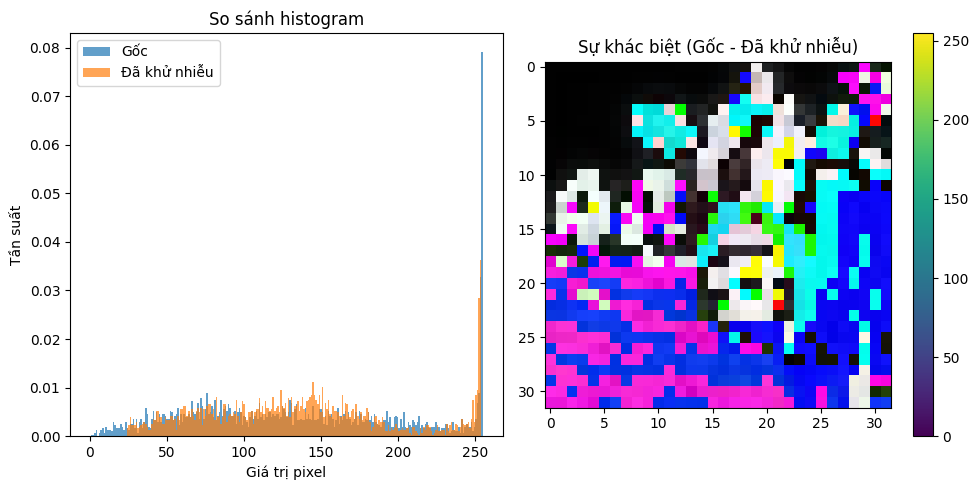

In [ ]:
# So sánh histograms trước và sau khi khử nhiễu
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(image_np.ravel(), bins=256, range=(0, 255), density=True, alpha=0.7, label='Gốc')
plt.hist(image_denoised.ravel(), bins=256, range=(0, 255), density=True, alpha=0.7, label='Đã khử nhiễu')
plt.title("So sánh histogram")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần suất")
plt.legend()

plt.subplot(122)
plt.imshow(np.abs(image_np - image_denoised).astype(int))
plt.title("Sự khác biệt (Gốc - Đã khử nhiễu)")
plt.colorbar()

plt.tight_layout()
plt.show()

##### Tải bộ dữ liệu đã được chuẩn hóa, in kích thước

In [ ]:
# help(torchvision.datasets.CIFAR100)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) #đã chuyển đổi ảnh thành tensor PyTorch và chuẩn hóa giá trị pixel từ đoạn [0,255] về [0,1]
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Số lượng mẫu huấn luyện: {len(trainset)}")
print(f"Số lượng mẫu kiểm tra: {len(testset)}")

Số lượng mẫu huấn luyện: 50000
Số lượng mẫu kiểm tra: 10000


In [ ]:
print(f"Loại của trainset: {type(trainset)}") # là 1 đối tượng dataset
first_item = trainset[0]
print(f"Loại của phần tử đầu tiên: {type(first_item)}")
print(f"Số lượng thành phần trong phần tử đầu tiên: {len(first_item)}")
print(f"Loại của hình ảnh: {type(first_item[0])}")
print(f"Loại của nhãn: {type(first_item[1])}")

# chứa nhiều đối tượng tuple có thành phần (image, target)
# với
# image: là 1 tensor chứa dữ liệu hình ảnh đã qua xử lý bởi transform (nếu có).
# target: là một số nguyên từ 0 đến 99, đại diện cho nhãn của hình ảnh.

Loại của trainset: <class 'torchvision.datasets.cifar.CIFAR100'>
Loại của phần tử đầu tiên: <class 'tuple'>
Số lượng thành phần trong phần tử đầu tiên: 2
Loại của hình ảnh: <class 'torch.Tensor'>
Loại của nhãn: <class 'int'>


##### Lấy ảnh đầu tiên phân tích

In [ ]:
image, label = trainset[0]
print(f"Kích thước: {image.shape}")
print(f"Nhãn: {label}")
print(f"Tên lớp: {trainset.classes[label]}")

Kích thước: torch.Size([3, 32, 32])
Nhãn: 19
Tên lớp: cattle


##### Xem phạm vi nhãn

In [ ]:
print(f"Số lượng lớp: {len(trainset.classes)}")
print(f"Nhãn và tên lớp tương ứng:")
for i, class_name in enumerate(trainset.classes):
    print(f"{i}: {class_name}")

Số lượng lớp: 100
Nhãn và tên lớp tương ứng:
0: apple
1: aquarium_fish
2: baby
3: bear
4: beaver
5: bed
6: bee
7: beetle
8: bicycle
9: bottle
10: bowl
11: boy
12: bridge
13: bus
14: butterfly
15: camel
16: can
17: castle
18: caterpillar
19: cattle
20: chair
21: chimpanzee
22: clock
23: cloud
24: cockroach
25: couch
26: crab
27: crocodile
28: cup
29: dinosaur
30: dolphin
31: elephant
32: flatfish
33: forest
34: fox
35: girl
36: hamster
37: house
38: kangaroo
39: keyboard
40: lamp
41: lawn_mower
42: leopard
43: lion
44: lizard
45: lobster
46: man
47: maple_tree
48: motorcycle
49: mountain
50: mouse
51: mushroom
52: oak_tree
53: orange
54: orchid
55: otter
56: palm_tree
57: pear
58: pickup_truck
59: pine_tree
60: plain
61: plate
62: poppy
63: porcupine
64: possum
65: rabbit
66: raccoon
67: ray
68: road
69: rocket
70: rose
71: sea
72: seal
73: shark
74: shrew
75: skunk
76: skyscraper
77: snail
78: snake
79: spider
80: squirrel
81: streetcar
82: sunflower
83: sweet_pepper
84: table
85: tank

In [ ]:
# # Lấy tất cả các nhãn
# labels = [label for _, label in trainset]
# labels_array = np.array(labels)

# unique_labels = np.unique(labels_array)
# num_unique_labels = len(unique_labels)
# print(f"Số lượng Nhãn (tương ứng với lớp): {num_unique_labels}")
# print(f"Tập hợp Nhãn: {unique_labels}")

#### Model Architecture

**Vision Transformer Model**

In [ ]:
class Attention(nn.Module):
    '''
    Attention Module used to perform self-attention operation allowing the model to attend
    information from different representation subspaces on an input sequence of embeddings.
    The sequence of operations is as follows :-

    Input -> Query, Key, Value -> ReshapeHeads -> Query.TransposedKey -> Softmax -> Dropout
    -> AttentionScores.Value -> ReshapeHeadsBack -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        _reshape_heads(inp) :-
        Changes the input sequence embeddings to reduced dimension according to the number
        of attention heads to parallelize attention operation
        (batch_size, seq_len, embed_dim) -> (batch_size * heads, seq_len, reduced_dim)

        _reshape_heads_back(inp) :-
        Changes the reduced dimension due to parallel attention heads back to the original
        embedding size
        (batch_size * heads, seq_len, reduced_dim) -> (batch_size, seq_len, embed_dim)

        forward(inp) :-
        Performs the self-attention operation on the input sequence embedding.
        Returns the output of self-attention as well as atttention scores
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim), (batch_size * heads, seq_len, seq_len)

    Examples:
        >>> attention = Attention(embed_dim, heads, activation, dropout)
        >>> out, weights = attention(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)

        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
# Check if Dropout should be used after second Linear Layer
class FeedForward(nn.Module):
    '''
    FeedForward Network with two sequential linear layers with GELU activation function
    ,applied to the output of self attention operation. The sequence of operations is as
    follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> FF = FeedForward(8, 1)
        >>> out = FF(inp)
    '''
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
class TransformerBlock(nn.Module):
    '''
    Transformer Block combines both the attention module and the feed forward module with layer
    normalization, dropout and residual connections. The sequence of operations is as follows :-

    Input -> LayerNorm1 -> Attention -> Residual -> LayerNorm2 -> FeedForward -> Output
      |                                   |  |                                      |
      |-------------Addition--------------|  |---------------Addition---------------|

    Args:
        embed_dim: Dimension size of the hidden embedding
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> TB = TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout)
        >>> out = TB(inp)
    '''
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res

        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner. The sequence
    of the operations is as follows -

    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        layers: Number of Transformer Blocks in the Transformer
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
        >>> transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [ ]:
# Not Exactly Same as Paper
class ClassificationHead(nn.Module):
    '''
    Classification Head attached to the first sequence token which is used as the arbitrary
    classification token and used to optimize the transformer model by applying Cross-Entropy
    loss. The sequence of operations is as follows :-

    Input -> FC1 -> GELU -> Dropout -> FC2 -> Output

    Args:
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classification classes in the dataset
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, embed_dim) -> (batch_size, classes)

    Examples:
        >>> CH = ClassificationHead(embed_dim, classes, dropout)
        >>> out = CH(inp)
    '''
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes)
        return out

In [ ]:
class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end to end model architecture which combines all the above modules
    in a sequential manner. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

    Args:
        patch_size: Length of square patch size
        max_len: Max length of learnable positional embedding
        embed_dim: Dimension size of the hidden embedding
        classes: Number of classes in the dataset
        layers: Number of Transformer Blocks in the Transformer
        channels: Number of channels in the input (Default=3)
        heads: Number of parallel attention heads (Default=8)
        activation: Optional activation function to be applied to the input while
                    transforming to query, key and value matrixes (Default=None)
        forward_expansion: The scale used to transform the input embedding to a higher dimension
                           and then scaled back to capture richer information (Default=1)
        dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        It outputs the classification output as well as the sequence output of the transformer
        (batch_size, channels, width, height) -> (batch_size, classes), (batch_size, seq_len+1, embed_dim)

    Examples:
        >>> ViT = VisionTransformer(atch_size, max_len, embed_dim, classes, layers, channels, heads, activation, forward_expansion, dropout)
        >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        #self.max_len = max_len không cho thay đổi dễ dàng
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)

        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))

        self.position_embed = nn.Parameter(torch.zeros((1, max_len + 1, embed_dim)))

        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()

        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim)
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)

        return class_out, out

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)

    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)

    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

##### ResNet Models

In [ ]:
class ResidualBlockSmall(nn.Module):
    '''
    ResidualBlockSmall implements the smaller block of the Residual Networks. It optionally also downsamples
    the input according to the stride to match the output while adding the residual. The sequence of operations
    is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Output
      |                                                              |
      |-----------------Residual_Downsample (Optional)---------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels, height, width)

    Examples:
        >>> RBS = ResidualBlockSmall(input_channels, out_channels, residual_downsample, stride)
        >>> out = RBS(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1):
        super(ResidualBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))

        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetSmall(nn.Module):
    '''
    ResNetSmall consists of layers of the smaller residual block defined above (ResidualBlockSmall).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset

    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetSmall(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetSmall, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=64, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=128, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=256, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        if stride != 1:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )

        layers.append(ResidualBlockSmall(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockSmall(output_channels, output_channels))

        return nn.Sequential(*layers)

In [ ]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)

    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))

        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out

In [ ]:
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset

    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output.
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )

        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet34(input_channels, classes):
    '''
    Initalization of ResNet34 using the layers as mentioned in the paper and using ResNetSmall module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset

    Output:
        ResNetSmall Object
    '''
    return ResNetSmall([3, 4, 6, 3], input_channels, classes)

In [ ]:
def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset

    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

#### Data Loading Functions

In [ ]:
def CIFAR100DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):
    '''
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    '''
    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar100, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

#### Training and Evaluation Functions

In [ ]:
# Initializations of all the constants used in the training and testing process

lr = 0.003
batch_size = 64 #256
num_workers = 2
shuffle = True
patch_size = 16 #4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 100
layers = 12
channels = 3
resnet_features_channels = 64
heads = 16
epochs = 100

In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

In [ ]:
def evaluation(model, dataloader, criterion, resnet_features=None):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

#### Model Initialization

Run either one the following subcells according to the models selected to train and test

##### Model - Vision Transformer

Recommended Values for the following Architecture

- patch_size = 4
- max_len = 100
- embed_dim = 512
- classes = 100
- layers = 12
- channels = 3
- heads = 16

In [ ]:
# Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

resnet_features = None

Recommended Values for the following Architecture

- patch_size = 7
- max_len = 100
- embed_dim = 512
- classes = According to Dataset
- layers = 12
- channels = 64 (Resnet Features Channels)
- heads = 16

In [ ]:
# Hybrid Vision Transformer Architecture

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=resnet_features_channels,
    heads=heads).to(device)

resnet_features = ResNetFeatures().to(device).eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Model - ResNet50 or ResNet34

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet34 Architecture

model = ResNet34(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

Recommended Values for the following Architecture

- input_channels = 3
- classes = According to Dataset


In [ ]:
# ResNet50 Architecture

model = ResNet50(
    input_channels=3,
    classes=classes).to(device)

resnet_features = None

#### Model Training and Evaluation

##### CIFAR100 Dataset

In [ ]:
train_dataloader = CIFAR100DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR100DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './drive/MyDrive/VisionTransformer/' + model.name + '_CIFAR100_checkpoint.pt')

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 782/782 [00:54<00:00, 14.31it/s]


Epoch : 1 - acc: 0.1123 - loss : 4.0113



100%|██████████| 157/157 [00:06<00:00, 25.32it/s]


test acc: 0.1775 - test loss : 3.5320



100%|██████████| 782/782 [00:52<00:00, 14.77it/s]


Epoch : 2 - acc: 0.1825 - loss : 3.4497



100%|██████████| 157/157 [00:04<00:00, 37.44it/s]


test acc: 0.2118 - test loss : 3.3468



100%|██████████| 782/782 [00:55<00:00, 13.99it/s]


Epoch : 3 - acc: 0.2238 - loss : 3.2087



100%|██████████| 157/157 [00:04<00:00, 32.30it/s]


test acc: 0.2554 - test loss : 3.0817



100%|██████████| 782/782 [00:52<00:00, 14.87it/s]


Epoch : 4 - acc: 0.2510 - loss : 3.0699



100%|██████████| 157/157 [00:04<00:00, 38.45it/s]


test acc: 0.2782 - test loss : 2.9233



100%|██████████| 782/782 [00:53<00:00, 14.72it/s]


Epoch : 5 - acc: 0.2765 - loss : 2.9415



100%|██████████| 157/157 [00:05<00:00, 30.27it/s]

test acc: 0.2899 - test loss : 2.8936



RuntimeError: Parent directory ./drive/MyDrive/VisionTransformer does not exist.

##### Plotting Results

In [ ]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
# print(train_accs)
# print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, 101), train_accs, label='Train Accuracy')
plt.plot(range(1, 101), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')